In [0]:
###Read Parquet File & Preview Data

# Path to uploaded Parquet file
parquet_path = "/FileStore/tables/yellow_tripdata_2025_02.parquet"

# Read parquet file
df_batch = spark.read.parquet(parquet_path)

# Show schema and sample data
df_batch.printSchema()
df_batch.show(5)

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: long (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: long (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- Airport_fee: double (nullable = true)
 |-- cbd_congestion_fee: double (nullable = true)

+--------+--------------------+---------------------+---------------+-------------+

In [0]:
##Save Data as Delta Table (Batch)
# Save as Delta table location for batch processing
df_batch.write.format("delta").mode("overwrite").save("/delta/taxi_trips_batch")

In [0]:
%sql
CREATE TABLE IF NOT EXISTS taxi_trips_batch
USING DELTA
LOCATION '/delta/taxi_trips_batch';

In [0]:
%sql
-- Trips per day
SELECT
  DATE(tpep_pickup_datetime) AS trip_date,
  COUNT(*) AS total_trips
FROM taxi_trips_batch
GROUP BY trip_date
ORDER BY trip_date DESC
LIMIT 10;

trip_date,total_trips
2025-03-01,1
2025-02-28,149455
2025-02-27,144052
2025-02-26,128974
2025-02-25,115804
2025-02-24,97348
2025-02-23,108970
2025-02-22,141862
2025-02-21,133980
2025-02-20,142246


In [0]:
%sql
-- Average fare by payment type
SELECT
  payment_type,
  ROUND(AVG(fare_amount), 2) AS avg_fare
FROM taxi_trips_batch
GROUP BY payment_type
ORDER BY avg_fare DESC;

payment_type,avg_fare
1,17.87
2,16.26
0,15.33
3,11.03
4,0.62


In [0]:
%sql
-- Running total trips by date
SELECT
  trip_date,
  total_trips,
  SUM(total_trips) OVER (ORDER BY trip_date) AS running_total_trips
FROM (
  SELECT
    DATE(tpep_pickup_datetime) AS trip_date,
    COUNT(*) AS total_trips
  FROM taxi_trips_batch
  GROUP BY trip_date
) sub;

trip_date,total_trips,running_total_trips
2025-01-31,30,30
2025-02-01,148649,148679
2025-02-02,123646,272325
2025-02-03,98476,370801
2025-02-04,119863,490664
2025-02-05,128369,619033
2025-02-06,126082,745115
2025-02-07,138099,883214
2025-02-08,146049,1029263
2025-02-09,123431,1152694


In [0]:
%sql
SELECT
  trip_date,
  total_trips,
  SUM(total_trips) OVER (ORDER BY trip_date) AS running_total_trips
FROM (
  SELECT
    DATE(tpep_pickup_datetime) AS trip_date,
    COUNT(*) AS total_trips
  FROM taxi_trips_batch
  GROUP BY trip_date
) sub;


trip_date,total_trips,running_total_trips
2025-01-31,30,30
2025-02-01,148649,148679
2025-02-02,123646,272325
2025-02-03,98476,370801
2025-02-04,119863,490664
2025-02-05,128369,619033
2025-02-06,126082,745115
2025-02-07,138099,883214
2025-02-08,146049,1029263
2025-02-09,123431,1152694


In [0]:
%sql
SELECT *
FROM (
  SELECT
    DATE(tpep_pickup_datetime) AS trip_date,
    SUM(total_amount) AS total_revenue,
    RANK() OVER (ORDER BY SUM(total_amount) DESC) AS revenue_rank
  FROM taxi_trips_batch
  GROUP BY trip_date
) ranked_trips
WHERE revenue_rank <= 5
ORDER BY revenue_rank;

trip_date,total_revenue,revenue_rank
2025-02-14,4042672.0599998757,1
2025-02-28,3834514.5299999258,2
2025-02-27,3769036.939999939,3
2025-02-13,3607450.989999953,4
2025-02-20,3506714.529999904,5


In [0]:
df_trips_per_day = spark.sql("""
SELECT
  DATE(tpep_pickup_datetime) AS trip_date,
  COUNT(*) AS total_trips
FROM taxi_trips_batch
GROUP BY trip_date
ORDER BY trip_date
""").toPandas()





In [0]:
df_trips_per_day.head()

,trip_date,total_trips
0,2025-01-31,30
1,2025-02-01,148649
2,2025-02-02,123646
3,2025-02-03,98476
4,2025-02-04,119863


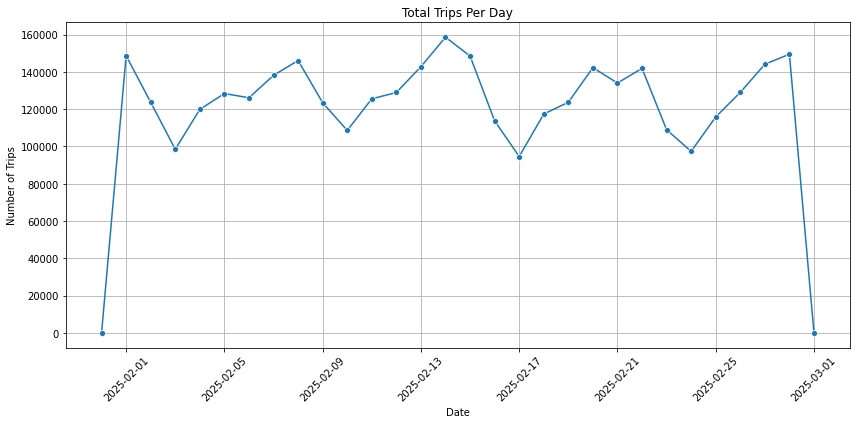

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,6))
sns.lineplot(data=df_trips_per_day, x='trip_date', y='total_trips', marker='o')
plt.xticks(rotation=45)
plt.title('Total Trips Per Day')
plt.xlabel('Date')
plt.ylabel('Number of Trips')
plt.grid(True)
plt.tight_layout()
plt.show()